In [ ]:
import tensorflow as tf
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-3ill_6_7
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-3ill_6_7
  Resolved https://github.com/tensorflow/docs to commit 2bcfa24e59cb9293fbb57d0c1e2f8b16ecf83e65
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2023.9.4.19335-py3-none-any.whl size=184104 sha256=5b44cf29e7388f0e9fc489f63d0304a46a93a888e371bb949420ee14c11a5948
  Stored in directory: /tmp/pip-ephem-wheel-cache-dtnx9u2y/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [ ]:
import cv2
import os #to interact with operating system

In [ ]:
!unzip /content/train_images.zip

In [ ]:
dataset_path = '/content/train_images'

# Initialize empty lists to store images and labels (if applicable)
images = []

# Iterate through the files in the dataset directory
for file_name in os.listdir(dataset_path): #The os.listdir() function returns a list of filenames found in the specified directory.
    if file_name.endswith('.png'):
        # Construct the full path to the image file
        image_path = os.path.join(dataset_path, file_name)#The os.path.join() function is used to construct a full file path by combining the dataset_path (the directory path) with the file_name

        # Load the image using OpenCV
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = image.astype(np.float32)#The code converts the image data to the float32 data type using NumPy's astype() method

        # Append the image to the list of images
        images.append(image)
train_images=np.array(images)
print(train_images.shape)

(520, 36, 36)


In [ ]:
train_images = train_images.reshape(  train_images.shape[0],36, 36, 1)#this 1 shows grayscale image
print(train_images.shape)
train_images = (train_images - 127.5) / 127.5

(520, 36, 36, 1)


In [ ]:
BUFFER_SIZE = 520
BATCH_SIZE = 8

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)#tf.data.Dataset.from_tensor_slices() is a function that takes a Python object (in this case, train_images) and converts it into a dataset where each element of the object becomes an element of the dataset.
# When you're training a machine learning model, it's crucial that the model learns to make predictions
# based on the actual patterns in the data rather than any accidental patterns or biases introduced by the order of the training examples



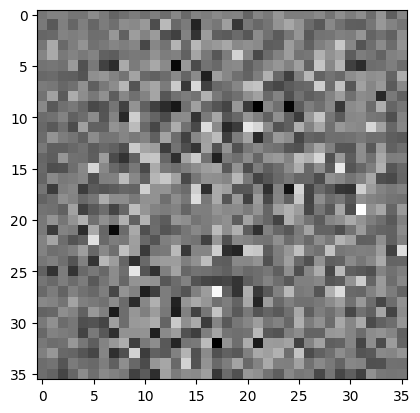

In [ ]:

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(9*9*256, use_bias=False, input_shape=(100,)))  # Adjust for 36x36 images
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((9, 9, 256)))  # Adjust for 36x36 images
    assert model.output_shape == (None, 9, 9, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 9, 9, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 18, 18, 64)  # Adjust for 36x36 images
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 36, 36, 1)  # Adjust for 36x36 images
    return model

generator= make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')


In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[36, 36, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00078207]], shape=(1, 1), dtype=float32)


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [ ]:
def train(dataset, epochs):
  history = []
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      g_loss, d_loss = train_step(image_batch)
      history.append([g_loss, d_loss])

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  return np.array(history)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

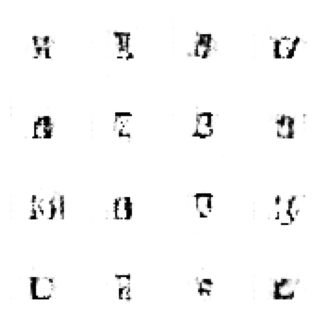

In [ ]:
training_history = train(train_dataset, EPOCHS)